# Analyzing Startup Fundraising Deals from Crunchbase

In this project, we'll practice using different techniques to work with larger datasets in pandas to analyze startup investments from [Crunchbase.com](https://www.crunchbase.com/).

Every year, thousands of startup companies raise financing from investors. Each time a startup raises money, we refer to the event as a fundraising round. Crunchbase is a website that crowdsources information on the fundraising rounds of many startups. The Crunchbase user community submits, edits, and maintains most of the information in Crunchbase.

In return, Crunchbase makes the data available through a web application and a fee-based API. Before Crunchbase switched to the paid API model, multiple groups crawled the site and released the data online. Because the information on the startups and their fundraising rounds is always changing, the data set we'll be using isn't completely up to date.

The data set of investments we'll be exploring, `crunchbase-investments.csv`, is current as of October 2013. It can be found on this [GitHub repo](https://github.com/datahoarder/crunchbase-october-2013/blob/master/crunchbase-investments.csv).

We'll practice working with different memory constraints throughout this project. Let's **assume we only have 10 megabytes of available memory**. While `crunchbase-investments.csv` consumes 10.3 megabytes of disk space, we know **pandas often requires 4 to 6 times amount of space in memory as the file does on disk** (especially when there's many string columns). We'll reduce memory so that in falls within our limits, then load the data into SQLite to do some analysis using a pandas/SQLite workflow.

Because the data set contains over 50,000 rows, we'll need to read the data set into dataframes using 5,000 row chunks to ensure that each chunk consumes much less than 10 megabytes of memory.

Across all of the chunks, become familiar with:
* Each column's missing value counts
* Each column's memory footprint
* The total memory footprint of all of the chunks combined
* Which column(s) we can drop because they aren't useful for analysis

## 1. Exploring the dataset

In [1]:
pip install --upgrade ipython

     |████████████████████████████████| 786 kB 4.8 MB/s eta 0:00:01
  Attempting uninstall: ipython
    Found existing installation: ipython 7.16.1
    Uninstalling ipython-7.16.1:
      Successfully uninstalled ipython-7.16.1
You should consider upgrading via the '/dataquest/system/env/python3/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pandas

     |████████████████████████████████| 10.6 MB 5.2 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.5
    Uninstalling pandas-1.0.5:
      Successfully uninstalled pandas-1.0.5
You should consider upgrading via the '/dataquest/system/env/python3/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import libraries we'll use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql

# Increase the max number of columns displayed in the notebook to 99
pd.options.display.max_columns = 99

# Display graphs in notebook
%matplotlib inline

# Graph formatting
sns.set(style='white', context='talk')
plt.style.use('dark_background')

# Look at first 5 rows
first_5 = pd.read_csv('crunchbase-investments.csv', nrows=5, encoding='Latin-1')
first_5.info(memory_usage='deep')
first_5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   company_permalink       5 non-null      object
 1   company_name            5 non-null      object
 2   company_category_code   5 non-null      object
 3   company_country_code    5 non-null      object
 4   company_state_code      4 non-null      object
 5   company_region          5 non-null      object
 6   company_city            4 non-null      object
 7   investor_permalink      5 non-null      object
 8   investor_name           5 non-null      object
 9   investor_category_code  4 non-null      object
 10  investor_country_code   5 non-null      object
 11  investor_state_code     5 non-null      object
 12  investor_region         5 non-null      object
 13  investor_city           5 non-null      object
 14  funding_round_type      5 non-null      object
 15  funded_at 

,company_permalink,company_name,company_category_code,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_category_code,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/company/advercar,AdverCar,advertising,USA,CA,SF Bay,San Francisco,/company/1-800-flowers-com,1-800-FLOWERS.COM,NaN,USA,NY,New York,New York,series-a,2012-10-30,2012-10,2012-Q4,2012,2000000
1,/company/launchgram,LaunchGram,news,USA,CA,SF Bay,Mountain View,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-23,2012-01,2012-Q1,2012,20000
2,/company/utap,uTaP,messaging,USA,NaN,United States - Other,NaN,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2012-01-01,2012-01,2012-Q1,2012,20000
3,/company/zoopshop,ZoopShop,software,USA,OH,Columbus,columbus,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,angel,2012-02-15,2012-02,2012-Q1,2012,20000
4,/company/efuneral,eFuneral,web,USA,OH,Cleveland,Cleveland,/company/10xelerator,10Xelerator,finance,USA,OH,Columbus,Columbus,other,2011-09-08,2011-09,2011-Q3,2011,20000


[5.579240798950195, 5.528232574462891, 5.535050392150879, 5.5282087326049805, 5.52435302734375, 5.553458213806152, 5.531436920166016, 5.5096588134765625, 5.396136283874512, 4.639497756958008, 2.6637144088745117]


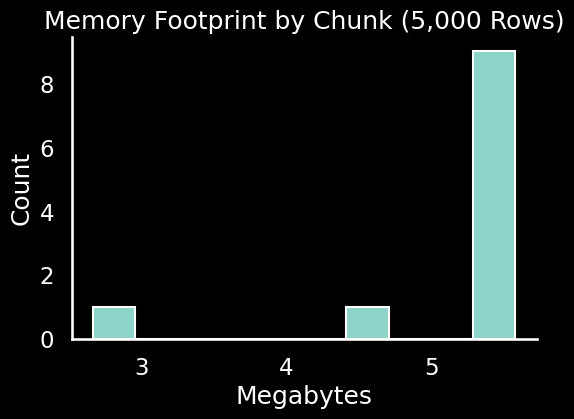

In [4]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')

# Calculate memory footprint of each chunk
memory_by_chunk = []
for chunk in chunk_iter:
    memory_by_chunk.append(chunk.memory_usage(deep=True).sum() / 2**20)
print(memory_by_chunk)

plt.hist(memory_by_chunk)
plt.title('Memory Footprint by Chunk (5,000 Rows)')
plt.xlabel('Megabytes')
plt.ylabel('Count')
sns.despine()
plt.show();

Using 5000 row chunks takes less than 6 MB of space, leaving us with 4 MB of breathing room.

In [5]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')

# Calculate the number of rows in the dataset by chunks
num_rows = 0
for chunk in chunk_iter:
    num_rows += (len(chunk))
    
print('There are {} rows in the dataframe.'.format(num_rows))

There are 52870 rows in the dataframe.


## 1.1 Missing values

Each column's missing value counts.

In [6]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')

# Store count of missing values for each chunk
missing_values =[]
for chunk in chunk_iter:
    missing_values.append(chunk.isnull().sum())

# Combine list of missing value counts in each chunk into one series
combined_missing_values = pd.concat(missing_values)
combined_missing_value_counts = combined_missing_values.groupby(combined_missing_values.index).sum()
combined_missing_value_counts.sort_values()

company_country_code          1
company_name                  1
company_permalink             1
company_region                1
investor_region               2
investor_permalink            2
investor_name                 2
funded_quarter                3
funded_at                     3
funded_month                  3
funded_year                   3
funding_round_type            3
company_state_code          492
company_city                533
company_category_code       643
raised_amount_usd          3599
investor_country_code     12001
investor_city             12480
investor_state_code       16809
investor_category_code    50427
dtype: int64

The majority of values are missing (>95%) for the `investor_category_code` column. We'll drop this column later.

## 1.2 Memory usage 

### 1.2a Memory usage by column

Each column's memory footprint.

In [7]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')

# Store memory usage of each column for each chunk
memory_by_col = []
for chunk in chunk_iter:
    memory_by_col.append(chunk.memory_usage(deep=True))

# Combine list of column memory footprints in each chunk into one series
memory_by_col_intermed = pd.concat(memory_by_col)
combined_memory_by_col = memory_by_col_intermed.groupby(
    memory_by_col_intermed.index).sum() / 2**20 ## Display in megabytes

# Drop memory footprint calculation for the index and sort values in descending order
combined_memory_by_col.drop('Index', inplace=True)
combined_memory_by_col.sort_values(ascending=False)

investor_permalink        4.749821
company_permalink         3.869808
investor_name             3.734270
company_name              3.424955
funded_at                 3.378091
company_city              3.343512
company_category_code     3.262619
company_region            3.253541
funding_round_type        3.252704
investor_region           3.238946
funded_month              3.226837
funded_quarter            3.226837
company_country_code      3.025223
company_state_code        2.962161
investor_city             2.751430
investor_country_code     2.524654
investor_state_code       2.361876
investor_category_code    0.593590
funded_year               0.403366
raised_amount_usd         0.403366
dtype: float64

### 1.2b Total memory footprint

Total memory footprint of all chunks combined.

In [8]:
 # Calculate the total memory footprint of the dataset
print(combined_memory_by_col.sum(), 'MB')

56.9876070022583 MB


### 1.2c Memory usage again, calculated using only a series, no lists

In [9]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', chunksize=5000, encoding='Latin-1')

# Calculate the memory footprint of each column
switch = 0
series_memory_footprint = pd.Series(dtype='float64')
for chunk in chunk_iter:
    if switch == 0:
        series_memory_footprint = chunk.memory_usage(deep=True)
        switch += 1
    else:
        series_memory_footprint += chunk.memory_usage(deep=True)

# Drop memory footprint calculation for the index and sort values in descending order
series_memory_footprint = series_memory_footprint.drop('Index').sort_values(ascending=False)
series_memory_footprint / 2**20

investor_permalink        4.749821
company_permalink         3.869808
investor_name             3.734270
company_name              3.424955
funded_at                 3.378091
company_city              3.343512
company_category_code     3.262619
company_region            3.253541
funding_round_type        3.252704
investor_region           3.238946
funded_quarter            3.226837
funded_month              3.226837
company_country_code      3.025223
company_state_code        2.962161
investor_city             2.751430
investor_country_code     2.524654
investor_state_code       2.361876
investor_category_code    0.593590
funded_year               0.403366
raised_amount_usd         0.403366
dtype: float64

In [10]:
 # Calculate the total memory footprint of the dataset
print((series_memory_footprint / 2**20).sum(), 'MB')

56.9876070022583 MB


## 1.3 Dropping columns

We'll drop columns that are unuseful for analysis, then include the undropped column names
in the `use_cols` parameter of `pd.read_csv`.

In [11]:
# Drop columns representing URL's or containing way too many missing values (>95% missing)
drop_cols = ['company_permalink', 'investor_permalink', 'investor_category_code']
use_cols = first_5.columns.drop(drop_cols).to_list()
use_cols

['company_name',
 'company_category_code',
 'company_country_code',
 'company_state_code',
 'company_region',
 'company_city',
 'investor_name',
 'investor_country_code',
 'investor_state_code',
 'investor_region',
 'investor_city',
 'funding_round_type',
 'funded_at',
 'funded_month',
 'funded_quarter',
 'funded_year',
 'raised_amount_usd']

In [12]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', usecols=use_cols,
                         chunksize=5000, encoding='Latin-1')

# Calculate the total memory footprint of the dataset
memory_usage = []
for chunk in chunk_iter:
    memory_usage.append(chunk.memory_usage(deep=True).sum() / 2**20)
print(sum(memory_usage), 'MB')

47.77576923370361 MB


## 2. Column datatypes

We'll get familiar with the column types before adding the data into SQLite by:
* Identifying the types for each column.
* Identifying the numeric columns we can represent using more space efficient types.
* For text columns:
    * Analyzing the unique value counts across all of the chunks to see if we can convert them to a numeric type.
    * Seeing if we clean clean any text columns and separate them into multiple numeric columns without adding any overhead when querying.
* Making changes to the code from the last step so that the overall memory the data consumes stays under 10 megabytes.

## 2.1 Identifying datatypes for each column

In [13]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', usecols=use_cols,
                         chunksize=5000, encoding='Latin-1')

# Determine column datatypes for each chunk
col_types = {}
for chunk in chunk_iter:
    for col in use_cols:
        if col in col_types:
            col_types[col].append(str(chunk[col].dtype))
        else:
            col_types[col] = [str(chunk[col].dtype)]

# Combine column dtypes to get rid of repeats using a dictionary of sets
combined_col_types = {}
for col in col_types:
    combined_col_types[col] = set(col_types[col])
combined_col_types

{'company_name': {'object'},
 'company_category_code': {'object'},
 'company_country_code': {'object'},
 'company_state_code': {'object'},
 'company_region': {'object'},
 'company_city': {'object'},
 'investor_name': {'object'},
 'investor_country_code': {'float64', 'object'},
 'investor_state_code': {'float64', 'object'},
 'investor_region': {'object'},
 'investor_city': {'float64', 'object'},
 'funding_round_type': {'object'},
 'funded_at': {'object'},
 'funded_month': {'object'},
 'funded_quarter': {'object'},
 'funded_year': {'float64', 'int64'},
 'raised_amount_usd': {'float64'}}

## 2.2 String column optimization

## 2.2a String column unique value counts

In [14]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', usecols=use_cols,
                         chunksize=5000, encoding='Latin-1')

# Calculate column values counts for each chunk
string_col_value_counts = {}
for chunk in chunk_iter:
    string_cols = chunk.select_dtypes(include='object').columns
    for col in string_cols:
        if col in string_col_value_counts:
            string_col_value_counts[col].append(chunk[col].value_counts(dropna=False))
        else:
            string_col_value_counts[col] = [chunk[col].value_counts(dropna=False)]

# Aggregate chunk column values counts
combined_value_counts = {}
for col in string_col_value_counts:
    series_value_counts = pd.concat(string_col_value_counts[col])
    final_value_counts = series_value_counts.groupby(series_value_counts.index, dropna=False).sum()
    combined_value_counts[col] = final_value_counts.sort_values(ascending=False)

# Display column value counts
for col in combined_value_counts:
    print(col)
    print('    Unique values: ', len(combined_value_counts[col]), '\n')
    print(combined_value_counts[col], '\n'*2)

company_name
    Unique values:  11574 

ecomom             58
Fab.com            57
Aperto Networks    49
Practice Fusion    47
Klout              46
                   ..
Media Lantern       1
Media Chaperone     1
MediProPharma       1
MediKeeper          1
NaN                 1
Name: company_name, Length: 11574, dtype: int64 


company_category_code
    Unique values:  44 

software            7243
web                 5015
biotech             4951
enterprise          4489
mobile              4067
advertising         3200
ecommerce           2168
cleantech           1948
games_video         1893
analytics           1863
hardware            1537
medical             1315
semiconductor       1292
network_hosting     1075
security             996
finance              931
social               920
education            783
health               670
public_relations     659
NaN                  643
search               632
other                481
messaging            452
fashion            

We can drop the `company_country_code` column since nearly all values are the same.

In [15]:
# Drop `company_country_code` column since it contains >95% of the same value
use_cols.remove('company_country_code')
use_cols

['company_name',
 'company_category_code',
 'company_state_code',
 'company_region',
 'company_city',
 'investor_name',
 'investor_country_code',
 'investor_state_code',
 'investor_region',
 'investor_city',
 'funding_round_type',
 'funded_at',
 'funded_month',
 'funded_quarter',
 'funded_year',
 'raised_amount_usd']

## 2.2b Converting string columns to category type

String columns with less than 50% unique values will take up less memory if converted to category type columns.

In [16]:
# Convert these string columns to category type
category_cols = {'funding_round_type':'category',
                 'investor_state_code':'category',
                 'investor_country_code':'category',
                 'investor_city':'category',
                 'investor_region':'category',
                 'investor_name':'category',
                 'company_state_code':'category',
                 'company_city':'category',
                 'company_category_code':'category',
                 'company_name':'category',
                }

In [17]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', usecols=use_cols, dtype=category_cols,
                         chunksize=5000, encoding='Latin-1')

# Calculate the total memory footprint of the dataset
memory_usage = []
for chunk in chunk_iter:
    memory_usage.append(chunk.memory_usage(deep=True).sum() / 2**20)
print(sum(memory_usage), 'MB')

19.280014038085938 MB


## 2.2 Converting dates to datetime

The `funded_at` column can be converted to datetime using the `parse_dates` arguement within `pd.read_csv`.

In [18]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', usecols=use_cols, dtype=category_cols,
                         parse_dates=['funded_at'], chunksize=5000, encoding='Latin-1')

# Calculate the total memory footprint of the dataset
memory_usage = []
for chunk in chunk_iter:
    memory_usage.append(chunk.memory_usage(deep=True).sum() / 2**20)
print(sum(memory_usage), 'MB')

16.305289268493652 MB


## 2.2d String columns to numeric

We'll analyze the unique values of string columns and convert to numeric where possible.

In [19]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', usecols=use_cols, dtype=category_cols,
                         parse_dates=['funded_at'],
                         chunksize=5000, encoding='Latin-1')

# Calculate memory footprint
memory_usage = []
for chunk in chunk_iter:
    # Convert `funded_quarter` column to an integer, fill nan values with 0
    funded_quarter = chunk['funded_quarter'].str.extract(r'Q(\d)', expand=False).fillna(0)
    chunk['funded_quarter'] = funded_quarter.astype('int8')
    
    # Convert `funded_month` column to an integer, fill nan values with 0
    funded_month = chunk['funded_month'].str.extract(r'-(\d\d)').fillna('0')
    chunk['funded_month'] = funded_month.astype('int8')
    
    memory_usage.append(chunk.memory_usage(deep=True).sum() / 2**20)
print(sum(memory_usage), 'MB')

9.9524564743042 MB


# 2.3 Optimizing numeric columns

We'll identify the numeric columns we can represent using more space efficient types.

In [20]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', usecols=use_cols, dtype=category_cols,
                         parse_dates=['funded_at'], chunksize=5000, encoding='Latin-1')

# Calculate minimum and maximum values for numeric columns
num_col_min_max = {}
for chunk in chunk_iter:
    numeric_cols = chunk.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        minimum = chunk[col].min()
        maximum = chunk[col].max()
        if col in num_col_min_max:
            if num_col_min_max[col][0] > minimum:
                num_col_min_max[col] = (minimum, num_col_min_max[col][1])
            if num_col_min_max[col][0] < maximum:
                num_col_min_max[col] = (num_col_min_max[col][0], maximum)

        else:
             num_col_min_max[col] = (minimum, maximum)

# Display (min,max) for each numeric column
for col, ranges in num_col_min_max.items():
    print(col, '(min, max): ', ranges)

funded_year (min, max):  (1987, 2013)
raised_amount_usd (min, max):  (1000.0, 275000000.0)


We can store numbers in the `funded_year`  column as `'int16` (2^16 = 65,536 whereas 2^8 = 256). The `raised_amount_usd` will stay as `float64` since we'll likely encounter overflow when we do calculations (2^32 = 4,294,967,296).

In [22]:
# Explicitly list columns we'll use
use_cols = ['company_name',
 'company_category_code',
 'company_state_code',
 'company_region',
 'company_city',
 'investor_name',
 'investor_country_code',
 'investor_state_code',
 'investor_region',
 'investor_city',
 'funding_round_type',
 'funded_at',
 'funded_month',
 'funded_quarter',
 'funded_year',
 'raised_amount_usd']

In [23]:
# Instatiate text file iterator with size 5000 rows 
chunk_iter = pd.read_csv('crunchbase-investments.csv', usecols=use_cols, dtype=category_cols,
                         parse_dates=['funded_at'], chunksize=5000, encoding='Latin-1')

# Calculate memory footprint
memory_usage = []
for chunk in chunk_iter:
    # Convert `funded_quarter` column to an integer, fill nan with 0 to avoid errors
    funded_quarter = chunk['funded_quarter'].str.extract(r'Q(\d)', expand=False).fillna(0)
    chunk['funded_quarter'] = funded_quarter.astype('int8')
    
    # Convert `funded_month` column to an integer, fill nan with 0 to avoid errors
    funded_month = chunk['funded_month'].str.extract(r'-(\d\d)').fillna('0')
    chunk['funded_month'] = funded_month.astype('int8')
    
    # Convert 'funded_year' column to an integer, fill nan with 0 to avoid errors
    chunk['funded_year'] = chunk['funded_year'].fillna(0).astype('int16')
    
    memory_usage.append(chunk.memory_usage(deep=True).sum() / 2**20)
print(sum(memory_usage), 'MB')

9.649931907653809 MB


The dataframe's total memory footprint is now below our 10 MB memory limit.

In [24]:
# Confirm changes
chunk.head()

,company_name,company_category_code,company_state_code,company_region,company_city,investor_name,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_type,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
50000,NuORDER,fashion,CA,Los Angeles,West Hollywood,Mortimer Singer,NaN,NaN,unknown,NaN,series-a,2012-10-01,10,4,2012,3060000.0
50001,ChaCha,advertising,IN,Indianapolis,Carmel,Morton Meyerson,NaN,NaN,unknown,NaN,series-b,2007-10-01,10,4,2007,12000000.0
50002,Binfire,software,FL,Bocat Raton,Bocat Raton,Moshe Ariel,NaN,NaN,unknown,NaN,angel,2008-04-18,4,2,2008,500000.0
50003,Binfire,software,FL,Bocat Raton,Bocat Raton,Moshe Ariel,NaN,NaN,unknown,NaN,angel,2010-01-01,1,1,2010,750000.0
50004,Unified Color,software,CA,SF Bay,South San Frnacisco,Mr. Andrew Oung,NaN,NaN,unknown,NaN,angel,2010-01-01,1,1,2010,NaN


## 3. Adding data into SQLite

Now we're in good shape to start exploring and analyzing the data. The next step is to load each chunk into a table in a SQLite database so we can query the full data set.

In [25]:
# Create connection to sql database
conn = sql.connect('crunchbase.db')

# Instatiate text file iterator with size 5000 rows and columns/dtypes we want to use
chunk_iter = pd.read_csv('crunchbase-investments.csv', usecols=use_cols, dtype=category_cols,
                         parse_dates=['funded_at'], chunksize=5000, encoding='Latin-1')

# Iterate over and process each chunk before adding data into a table in SQLite
for chunk in chunk_iter:
    # Convert `funded_quarter` column to an integer, fill nan with 0 to avoid errors
    funded_quarter = chunk['funded_quarter'].str.extract(r'Q(\d)', expand=False).fillna(0)
    chunk['funded_quarter'] = funded_quarter.astype('int8')
    
    # Convert `funded_month` column to an integer, fill nan with 0 to avoid errors
    funded_month = chunk['funded_month'].str.extract(r'-(\d\d)').fillna('0')
    chunk['funded_month'] = funded_month.astype('int8')
    
    # Convert 'funded_year' column to an integer, fill nan with 0 to avoid errors
    chunk['funded_year'] = chunk['funded_year'].fillna(0).astype('int16')
    
    # Add chunk data to `investments` table in sqlite
    chunk.to_sql("investments", conn, if_exists='append', index=False)

In [26]:
# Query the new table to make sure the data types match up
sql_dtypes = pd.read_sql("""
PRAGMA table_info(investments);
""", conn)

sql_dtypes

,cid,name,type,notnull,dflt_value,pk
0,0,company_name,TEXT,0,None,0
1,1,company_category_code,TEXT,0,None,0
2,2,company_state_code,TEXT,0,None,0
3,3,company_region,TEXT,0,None,0
4,4,company_city,TEXT,0,None,0
5,5,investor_name,TEXT,0,None,0
6,6,investor_country_code,TEXT,0,None,0
7,7,investor_state_code,TEXT,0,None,0
8,8,investor_region,TEXT,0,None,0
9,9,investor_city,TEXT,0,None,0


Data types are correct.

## 4. Querying data with pandas and SQLite

Now that the data is in SQLite, we can use the pandas SQLite workflow to explore and analyze startup investments.

Each row isn't a unique company, but a unique investment from a single investor. This means that many startups will span multiple rows.

We'll use queries to answer the following questions:
* What proportion of the total amount of funds did the top 10% raise? What about the top 1%? Compare these values to the proportions the bottom 10% and bottom 1% raised.
* Which categories of companies attracted the most investments?
* Which investors contributed the most money (across all startups)?
* Which investors contributed the most money per startup?
* Which funding round was the most popular? Which was the least popular?

## 4.1a Funding raised by top 10% of companies

In [27]:
# Calculate the total amount of funds in the dataset
total_funds = pd.read_sql("""
SELECT SUM(raised_amount_usd) AS total
  FROM investments;
""", conn)

# Results of query are in a dataframe. Isolate the total value and print
total_funds = total_funds.iloc[0,0]
print('The dataset includes ${} trillion in funding.'.format(round(total_funds / 10**12, 3)))

The dataset includes $6.723 trillion in funding.


In [28]:
# Funding raised by the top 10% of companies
top10pct_funding = pd.read_sql("""

SELECT company_name,
       raised_amount_usd,
       (CAST(raised_amount_usd AS FLOAT) / (SELECT SUM(raised_amount_usd)
                                             FROM investments)
                                             ) * 100 AS percentage_of_total_raised
  FROM investments
 WHERE raised_amount_usd > 0
 GROUP BY company_name
 ORDER BY raised_amount_usd DESC
 LIMIT (SELECT CAST(COUNT(DISTINCT company_name)*.1 AS INTEGER) 
          FROM investments
         WHERE raised_amount_usd > 0);
 """, conn)

top10pct_funding = top10pct_funding['raised_amount_usd'].sum()

print('The top 10% of companies raised ${} billion in funding.'.format(
      round(top10pct_funding / 10**9, 3)))

The top 10% of companies raised $62.338 billion in funding.


## 4.1b Funding raised by top 1% of companies

In [29]:
# Funding raised by the top 1% of companies
top1pct_funding = pd.read_sql("""

SELECT company_name,
       raised_amount_usd,
       (CAST(raised_amount_usd AS FLOAT) / (SELECT SUM(raised_amount_usd)
                                             FROM investments)
                                             ) * 100 AS percentage_of_total_raised
  FROM investments
 WHERE raised_amount_usd > 0
 GROUP BY company_name
 ORDER BY raised_amount_usd DESC
 LIMIT (SELECT CAST(COUNT(DISTINCT company_name)*.01 AS INTEGER) 
          FROM investments
         WHERE raised_amount_usd > 0);
 """, conn)

top1pct_funding = top1pct_funding['raised_amount_usd'].sum()

print('The top 1% of companies raised ${} billion in funding.'.format(
      round(top1pct_funding / 10**9, 3)))

The top 1% of companies raised $23.749 billion in funding.


## 4.1c Funding raised by bottom 10%

In [30]:
# Funding raised by the bottom 10% of companies
bottom10pct_funding = pd.read_sql("""

SELECT company_name,
       raised_amount_usd,
       (CAST(raised_amount_usd AS FLOAT) / (SELECT SUM(raised_amount_usd)
                                             FROM investments)
                                             ) * 100 AS percentage_of_total_raised
  FROM investments
 WHERE raised_amount_usd > 0
 GROUP BY company_name
 ORDER BY raised_amount_usd
 LIMIT (SELECT CAST(COUNT(DISTINCT company_name)*.1 AS INTEGER) 
          FROM investments
         WHERE raised_amount_usd > 0);
 """, conn)

bottom10pct_funding = bottom10pct_funding['raised_amount_usd'].sum()

print('The bottom 10% of companies raised ${} million in funding.'.format(
       round(bottom10pct_funding / 10**6, 3)))

The bottom 10% of companies raised $118.385 million in funding.


## 4.1d Funding raised by bottom 1%

In [31]:
# Funding raised by the bottom 1% of companies
bottom1pct_funding = pd.read_sql("""

SELECT company_name,
       raised_amount_usd,
       (CAST(raised_amount_usd AS FLOAT) / (SELECT SUM(raised_amount_usd)
                                             FROM investments)
                                             ) * 100 AS percentage_of_total_raised
  FROM investments
 WHERE raised_amount_usd > 0
 GROUP BY company_name
 ORDER BY raised_amount_usd
 LIMIT (SELECT CAST(COUNT(DISTINCT company_name)*.01 AS INTEGER) 
          FROM investments
         WHERE raised_amount_usd > 0);
 """, conn)

bottom1pct_funding = bottom1pct_funding['raised_amount_usd'].sum()

print('The bottom 1% of companies raised ${} million in funding.'.format(
       round(bottom1pct_funding / 10**6,3)))

The bottom 1% of companies raised $1.356 million in funding.


## 4.1e Comparing funding extremes

We'll compare the total amount of funds at the top and bottom of the scales.

In [32]:
# Ratio comparing top and bottom 10% of total funding
top10pct_funding / bottom10pct_funding

526.5744038811017

In [33]:
# Ratio comparing top and bottom 1% of total funding
top1pct_funding / bottom1pct_funding

17519.46283510885

**Bottom Line:** The top 10% of companies received over 525 times more funding than the bottom 10%. Meanwhile, the **top 1% of companies received 17,500 times more funding than the bottom 1%.**

## 4.2a Most funding raised by category

Which category of company attracted the most investments? The least?

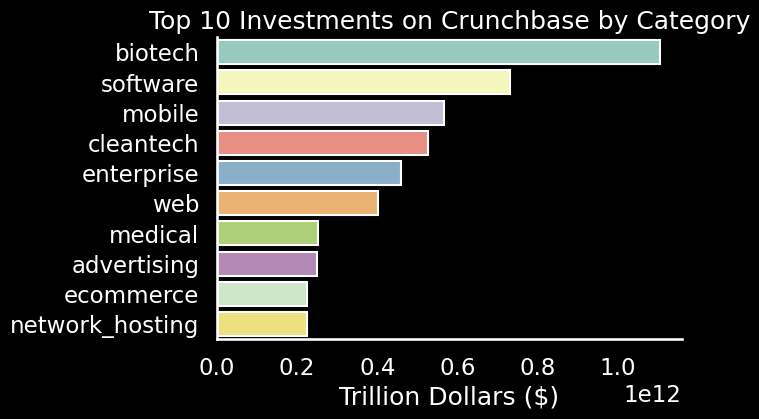

,category,funding
0,biotech,1103964230620
1,software,730845167240
2,mobile,567561542800
3,cleantech,527052250280
4,enterprise,458609272730
5,web,401432649890
6,medical,253671052810
7,advertising,250766618790
8,ecommerce,225672200710
9,network_hosting,224196838400


In [56]:
# Query for the top 10 most funded categories
top_categories = pd.read_sql("""
SELECT company_category_code AS category,
       SUM(raised_amount_usd) AS funding
  FROM investments
 GROUP BY 1
 ORDER BY 2 DESC
 LIMIT 10;
 """, conn)

# Plot the top 10 categories 
sns.barplot(x='funding', y='category', data=top_categories)
plt.title('Top 10 Investments on Crunchbase by Category')
plt.xlabel('Trillion Dollars ($)')
plt.ylabel('')
sns.despine()
plt.show();

# Show table
top_categories

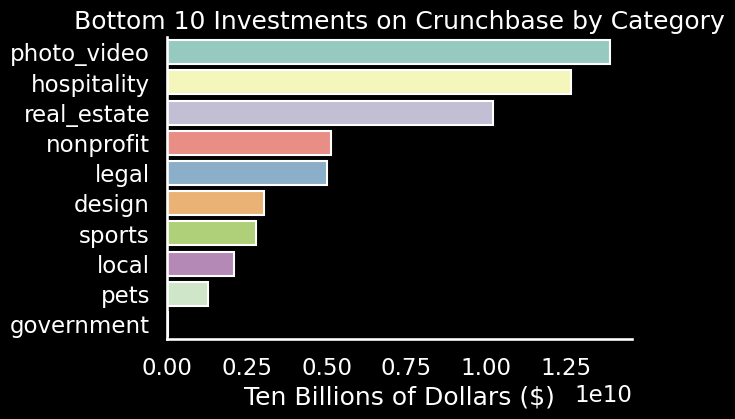

,category,funding
9,photo_video,13896485000
8,hospitality,12674349240
7,real_estate,10209635640
6,nonprofit,5138348200
5,legal,5013680000
4,design,3026400000
3,sports,2790450000
2,local,2103600000
1,pets,1289800000
0,government,11875000


In [55]:
# Query for the bottom 10 least funded categories
top_categories = pd.read_sql("""
SELECT company_category_code AS category,
       SUM(raised_amount_usd) AS funding
  FROM investments
 WHERE category != '2/7/08'
 GROUP BY 1
 ORDER BY 2
 LIMIT 10;
 """, conn)

# Plot the bottom 10 categories 
sns.barplot(x='funding', y='category', 
            data=top_categories.sort_values('funding', ascending=False))
plt.title('Bottom 10 Investments on Crunchbase by Category')
plt.xlabel('Ten Billions of Dollars ($)')
plt.ylabel('')
sns.despine()
plt.show();

# Show table
top_categories.sort_values('funding', ascending=False)

## 4.3 Top 10 investors

Which investors contributed the most money (across all startups)?

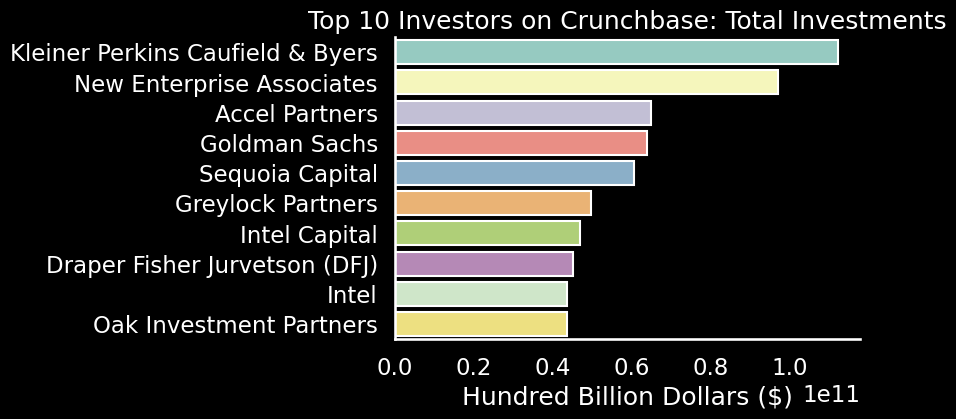

,investor,invested
0,Kleiner Perkins Caufield & Byers,112178263760
1,New Enterprise Associates,96925423440
2,Accel Partners,64721261990
3,Goldman Sachs,63754590000
4,Sequoia Capital,60394024100
5,Greylock Partners,49609829390
6,Intel Capital,46956167550
7,Draper Fisher Jurvetson (DFJ),45014612380
8,Intel,43649549056
9,Oak Investment Partners,43500647270


In [58]:
# Query for the top 10 investors by total investments
big_investors = pd.read_sql("""
SELECT investor_name AS investor,
       SUM(raised_amount_usd) AS invested
  FROM investments
 GROUP BY 1
 ORDER BY 2 DESC
 LIMIT 10;
 """, conn)

# Plot the top 10 investors
sns.barplot(x='invested', y='investor', data=big_investors)
plt.title('Top 10 Investors on Crunchbase: Total Investments')
plt.xlabel('Hundred Billion Dollars ($)')
plt.ylabel('')
sns.despine()
plt.show();

# Show table
big_investors

## 4.4 Top investors (money per startup)

Which investors contributed the most money per startup?

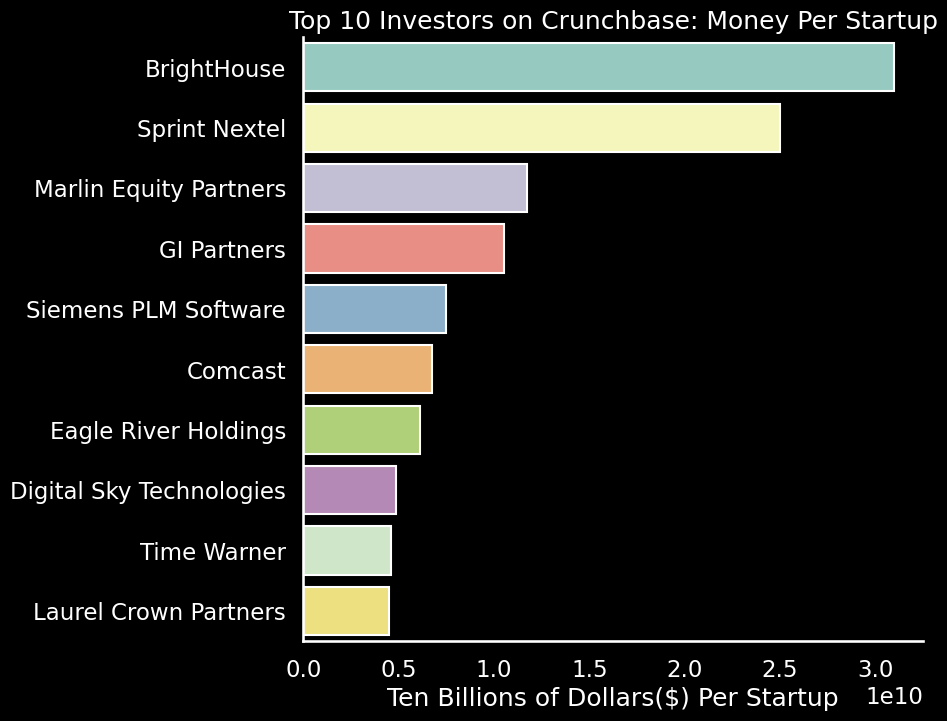

,investor,money_per_startup
0,BrightHouse,3.095755e+10
1,Sprint Nextel,2.500000e+10
2,Marlin Equity Partners,1.175755e+10
3,GI Partners,1.050000e+10
4,Siemens PLM Software,7.500000e+09
5,Comcast,6.774592e+09
6,Eagle River Holdings,6.142500e+09
7,Digital Sky Technologies,4.869678e+09
8,Time Warner,4.584172e+09
9,Laurel Crown Partners,4.500000e+09


In [60]:
# Query for the top 10 investors by money per startup
top_invested_per_startup = pd.read_sql("""
SELECT investor_name AS investor,
       (SUM(raised_amount_usd)) / CAST(COUNT(DISTINCT company_name) AS FLOAT) AS money_per_startup
  FROM investments
 GROUP BY 1
 ORDER BY 2 DESC
 LIMIT 10;
 """, conn)

# Plot the top 10 investors by money per startup
fig = plt.figure(figsize=(8,8))
sns.barplot(x='money_per_startup', y='investor', data=top_invested_per_startup)
plt.title('Top 10 Investors on Crunchbase: Money Per Startup')
plt.xlabel('Ten Billions of Dollars($) Per Startup')
plt.ylabel('')
sns.despine()
plt.show();

# Show table
top_invested_per_startup

## 4.5 Funding round popularity

Which funding round was the most popular? Which was the least popular?

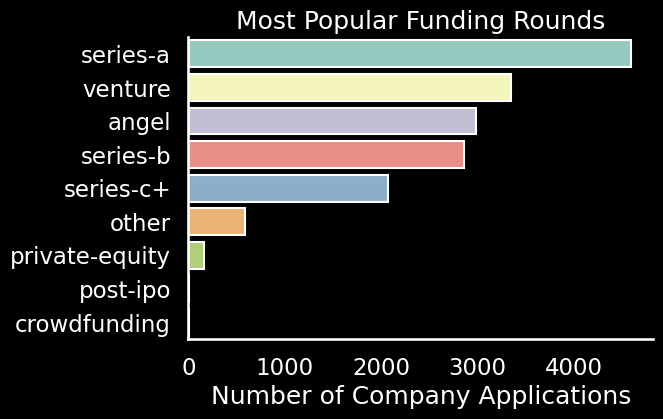

,funding_type,number_of_companies
0,series-a,4590
1,venture,3341
2,angel,2977
3,series-b,2855
4,series-c+,2072
5,other,584
6,private-equity,160
7,post-ipo,10
8,crowdfunding,3
9,None,2


In [38]:
# Query ranking the funding rounds by most company applications
funding_round = pd.read_sql("""
SELECT funding_round_type AS funding_type,
       COUNT(DISTINCT company_name) AS number_of_companies
  FROM investments
 GROUP BY 1
 ORDER BY 2 DESC;
""", conn)

# Plot the funding round rankings
sns.barplot(x='number_of_companies', y='funding_type', data=funding_round)
plt.title('Most Popular Funding Rounds')
plt.xlabel('Number of Company Applications')
plt.ylabel('')
sns.despine()
plt.show();

# Show table
funding_round

## Conclusion

Limited to 10 MB of memory, we used chunk processing to optimize the memory footprint of a dataframe containing info on startup investments from [Crunchbase.com](https://www.crunchbase.com/) circa October 2013. 

Following a reduction in memory from ~59 MB to ~9 MB, we uploaded the dataframe to the `investments` table in SQLite, and analyzed the dataset to discover that:

* The top 10% of companies received ~526 times more funding than the bottom 10% <br>
  (\\$62.338 billion vs. \\$118.385 million)
* The top 1% of companies received over 17,500 times more funding than the bottom 1% <br>
   (\\$23.749 billion vs. \\$1.356 million)
* Biotech attracted the most investments by a wide margin (> \\$1 trillion), receiving over \\$400 billion more than software, the 2nd most invested-in category.
* Government was the least invested-in category, receiving just under \\$12 million in funding.
* Kleiner Perkins Caufield & Byers contributed the most money, totalling over \\$100 billion in investments. New Enterprise Associates contributed the 2nd most money (~\\$96 billion) and are ahead of the 3rd largest contributor, Accel Partners, by over \\$30 billion.
* BrightHouse and Sprint Nextel invested the most money per startup, investing over \\$30 billion per startup and \\$25 billion respectively. The 3rd most money per startup was contributed by Marlin Equity Partnes, totalling over \\$10 billion per startup.
* Series-a is the most popular funding round, followed by venture and angel, which makes sense since these types of funding are usually sought out in the intial stages of a company.

### Next steps

Here are some ideas for further exploration:

* Repeat the tasks in this guided project using stricter memory constraints (under 1 megabyte).
* Clean and analyze the other Crunchbase data sets from the same GitHub repo.
    * Understand which columns the data sets share, and how the data sets are linked.
    * Create a relational database design that links the data sets together and reduces the overall disk space the database file consumes.
    * Use pandas to populate each table in the database, create the appropriate indexes, and so on.